# InterFaceGAN Usage Demo
Adapted from https://colab.research.google.com/github/genforce/interfacegan/blob/master/docs/InterFaceGAN.ipynb#scrollTo=ijKTlG5GeTd3
(If running the original edit.py make sure to change model_settings.py's USE_CUDA to False if you're not running on an nVidia GPU)

## Download pre-trained PGGAN and StyleGAN models / Install modules

In [5]:
!powershell curl "https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1" -o models/pretrain/pggan_celebahq.pth 
!powershell curl "https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1" -o models/pretrain/stylegan_celebahq.pth 
!powershell curl "https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1" -o models/pretrain/stylegan_ffhq.pth

In [ ]:
!pip install IPython
!pip install numpy
!pip install opencv-python
!pip install pillow
!pip install torch
!pip install sklearn
!pip install tqdm

## Defining Helper and Utility Functions

In [3]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image
import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
    """Builds the generator by model name."""

    # Either chose a PGGAN or StyleGAN generator
    gan_type = MODEL_POOL[model_name]['gan_type']
    if gan_type == 'pggan':
        generator = PGGANGenerator(model_name)
    elif gan_type == 'stylegan':
        generator = StyleGANGenerator(model_name)
    return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
    """Samples latent codes randomly."""
    np.random.seed(seed)
    codes = generator.easy_sample(num)
    if generator.gan_type == 'stylegan' and latent_space_type == 'W':
        codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
        codes = generator.get_value(generator.model.mapping(codes))
    return codes


def imshow(images, col, viz_size=256):
    """Shows images in one figure."""
    num, height, width, channels = images.shape
    assert num % col == 0
    row = num // col

    fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        
        if height != viz_size or width != viz_size:
            image = cv2.resize(image, (viz_size, viz_size))
            fused_image[y:y + viz_size, x:x + viz_size] = image

    fused_image = np.asarray(fused_image, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(fused_image).save(data, 'jpeg')
    im_data = data.getvalue()
    disp = IPython.display.display(IPython.display.Image(im_data))
    return disp

## Chose a downloaded model and load the pre-learned hyperplane boundaries

In [6]:
#Multiple GANs are pretrained with boundaries ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
model_name = "pggan_celebahq" 

# Chose latent space W or Z
latent_space_type = "W" 

# Create a generator matching the selected model name
generator = build_generator(model_name)

# Load the SVM pre-trained hyperplane models
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
    boundary_name = f'{model_name}_{attr_name}'
    if generator.gan_type == 'stylegan' and latent_space_type == 'W':
        boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
    else:
        boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

[2021-09-29 21:14:49,300][INFO] Loading pytorch model from `models/pretrain/pggan_celebahq.pth`.
[2021-09-29 21:14:49,441][INFO] Successfully loaded!
[2021-09-29 21:14:49,442][INFO]   `lod` of the loaded model is 0.0.


## Generate latent codes

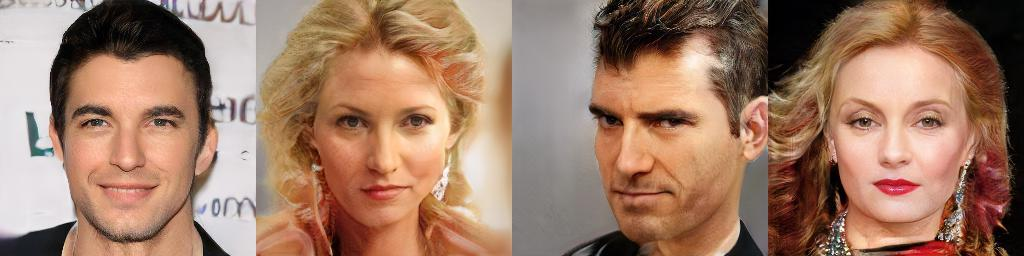

In [16]:
num_samples = 4
noise_seed = 147

# Generate the latent codes
latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    synthesis_kwargs = {'latent_space_type': 'W'}
else:
    synthesis_kwargs = {}

# Show the generated images
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

## Editing the learned attributes

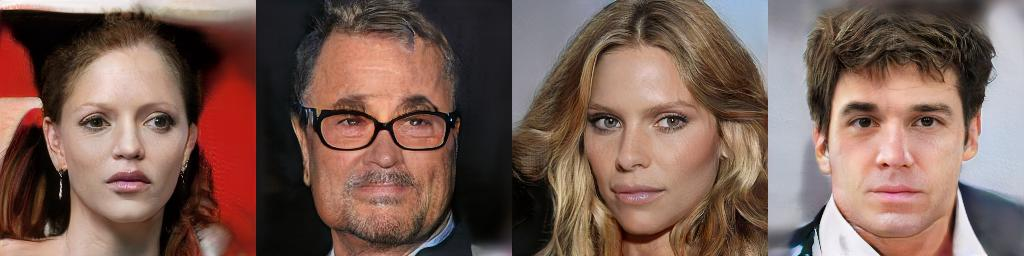

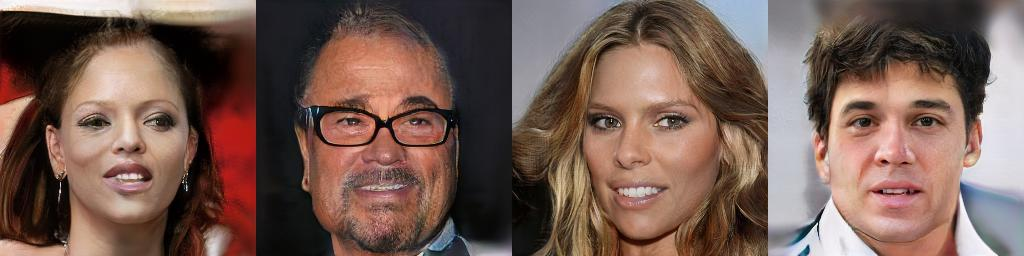

In [15]:
# Change these attributes in an interval [-3 ; 3]
age        = 0 
eyeglasses = 0
gender     = 0 
pose       = 0 
smile      = 1.9

# Apply the selected attribute values to our latent codes
new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
    new_codes += boundaries[attr_name] * eval(attr_name)

# Generate new faces from the modified codes
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)
imshow(new_images, col=num_samples)